# TSNE

## Datos

El archivo audio_caps_embeddings.csv contiene una representación vectorial (embedding) para cada descriptor musical o caption del dataset MusicCaps, que se generó empleando el modelo CLAP_Module, que fue previamente entrenado para alinear información texto-audio.
Cada embedding representa el contenido semántico de un descriptor musical en un espacio latente multimodal.

El archivo tiene las columnas:

- text: el descriptor o frase musical (“emphatic drumming”).

- embedding: el vector de características correspondiente (normalizado y de dimensión 512).

## Objetivo

Analizar y comparar la representación semántica de los descriptores musicales generados a partir de los prompts base (asociados a los cuatro sabores: sweet, sour, salty y bitter) con respecto a los embeddings derivados del conjunto de datos AudioCaps, utilizando técnicas de reducción de dimensionalidad y análisis de agrupamiento no supervisado.

## Conceptos

CLAP (“Contrastive Language-Audio Pretraining”) es un modelo cross-modal que aprende una representación compartida entre texto y audio.

Internamente, el modelo tiene dos encoders:

- Text Encoder: convierte texto en embeddings.

- Audio Encoder: convierte audio en embeddings.




In [1]:
!pip install laion-clap

In [38]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import sys
import os
import plotly.express as px
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Dict
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from laion_clap import CLAP_Module

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/AudioPrompt')
from scripts.types import MusicGenData, MusicGenCLAPResult

## 1. Graficar T-SNE

1. Cargar los datos

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {DEVICE}")

tracks_base_data_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music"
data_clap_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/tsne.csv"
df_no_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/no_funsion.csv"
df_yes_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/funsion.csv"
data_both_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/both.csv"
audio_caps_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/audio_caps_embeddings.csv"


Dispositivo: cpu


In [7]:
df_audio_caps = pd.read_csv(audio_caps_path)
df_audio_caps

,text,embedding
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -..."
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0..."
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -..."
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -..."
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -..."
...,...,...
13153,baptist choir,"[-0.04487796127796173, 0.04352131485939026, -0..."
13154,clean sounding,"[-0.044880855828523636, 0.0430021695792675, -0..."
13155,bhangara beats,"[-0.043108921498060226, 0.04383450746536255, -..."
13156,korean indie rock,"[-0.045442331582307816, 0.04396533593535423, -..."


2. Convertir el string de lista a un vector NumPy

In [9]:
df_audio_caps["embedding"] = df_audio_caps["embedding"].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))

print(f"Total de descriptores cargados: {len(df_audio_caps)}")
print(f"Dimensión del embedding: {len(df_audio_caps['embedding'].iloc[0])}")

Total de descriptores cargados: 13158
Dimensión del embedding: 512


3. Crear matriz de embeddings (N x D)

In [11]:
X = np.stack(df_audio_caps["embedding"].values)

4. Reducir dimensión con PCA

In [12]:
pca = PCA(n_components=min(50, X.shape[1] - 1))
X_pca = pca.fit_transform(X)
print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")

Varianza explicada por PCA: 77.14%


5. Aplicar t-SNE

In [13]:
tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    max_iter=2000,
    metric="cosine",
    random_state=42,
    init="pca"
)
X_tsne = tsne.fit_transform(X_pca)

df_audio_caps["tsne_1"] = X_tsne[:, 0]
df_audio_caps["tsne_2"] = X_tsne[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [14]:
df_audio_caps

,text,embedding,tsne_1,tsne_2
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -...",10.673228,76.386230
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0...",25.510283,-3.883231
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -...",33.408302,-14.000141
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -...",12.517638,55.172001
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -...",-30.439711,-53.130627
...,...,...,...,...
13153,baptist choir,"[-0.04487796127796173, 0.04352131485939026, -0...",47.497318,-73.870399
13154,clean sounding,"[-0.044880855828523636, 0.0430021695792675, -0...",49.654587,-22.150232
13155,bhangara beats,"[-0.043108921498060226, 0.04383450746536255, -...",43.317581,-27.818516
13156,korean indie rock,"[-0.045442331582307816, 0.04396533593535423, -...",39.382015,-67.396179


6. Visualización con Seaborn

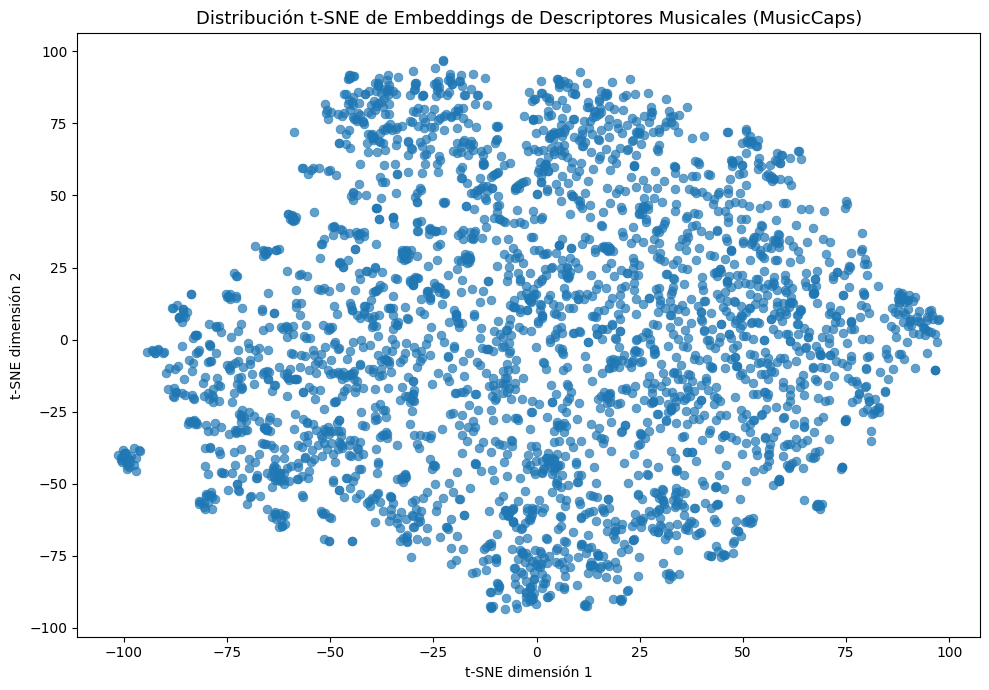

In [15]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_audio_caps.sample(min(3000, len(df_audio_caps))),  # Muestra hasta 3000 puntos para mejor rendimiento.
    x="tsne_1",
    y="tsne_2",
    s=40,
    alpha=0.7,
    edgecolor=None
)
plt.title("Distribución t-SNE de Embeddings de Descriptores Musicales (MusicCaps)", fontsize=13)
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.tight_layout()
plt.show()

In [16]:
fig = px.scatter(
    df_audio_caps.sample(min(3000, len(df_audio_caps))),
    x="tsne_1",
    y="tsne_2",
    hover_data=["text", "audio_id"] if {"text", "audio_id"}.issubset(df_audio_caps.columns) else None,
    title="Distribución interactiva t-SNE de embeddings de MusicCaps",
    template="plotly_white",
    opacity=0.7
)
fig.update_traces(marker=dict(size=5))
fig.show()

## 2. Métricas para evaluar la calidad del espacio de embeddings

### Silhouette Score

Evalúa qué tan bien separado está cada punto respecto a los demás clusters.
Valores:

≈ 1 → clusters bien definidos

≈ 0 → clusters mezclados

< 0 → puntos mal clasificados o superpuestos


Seleccionar el número de clústers adecuado:

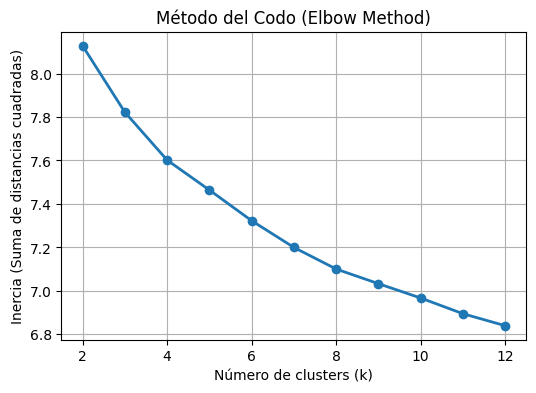

In [24]:
def elbow_method(X, max_k=15):
    inertias = []
    K = range(2, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(K, inertias, 'o-', linewidth=2)
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia (Suma de distancias cuadradas)')
    plt.title('Método del Codo (Elbow Method)')
    plt.grid(True)
    plt.show()

elbow_method(X_pca, max_k=12)

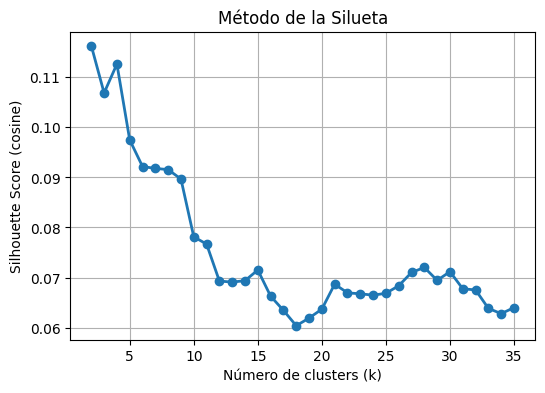

In [25]:
def silhouette_method(X, max_k=12):
    scores = []
    K = range(2, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels, metric='cosine')
        scores.append(score)

    plt.figure(figsize=(6, 4))
    plt.plot(K, scores, 'o-', linewidth=2)
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhouette Score (cosine)')
    plt.title('Método de la Silueta')
    plt.grid(True)
    plt.show()

silhouette_method(X_pca, max_k=35)

El pico visual en la curva de silueta muestra el punto 4 como una buena estructura de clusters.

➡️ k = 4, significa que con 4 clusters se logra una buena compacidad sin sobreajustar.

Esto suele coincidir con una estructura de orden medio (por ejemplo, 4 grupos semánticos amplios dentro de los descriptores musicales).

In [22]:
dbscan = DBSCAN(eps=0.3, min_samples=10, metric='cosine')
labels = dbscan.fit_predict(X_pca)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Número estimado de clusters: {n_clusters}")

Número estimado de clusters: 32


In [26]:
n_clusters = 32
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

silhouette = silhouette_score(X_pca, labels, metric="cosine")
print(f"Silhouette Score (cosine): {silhouette:.4f}")

Silhouette Score (cosine): 0.0675


In [28]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

silhouette = silhouette_score(X_pca, labels, metric="cosine")
print(f"Silhouette Score (cosine): {silhouette:.4f}")

Silhouette Score (cosine): 0.1127


#### Silhouette

El valor del Silhouette Score oscila entre -1 y 1:

- Cercano a 1: Clusters bien separados.

- Cercano a 0: Solapamiento entre clusters (espacio continuo).

- Negativo: Elementos mal asignados.

Actualmente:

k = 4 es 0.1127

k = 32 es 0.0675

Ambos son bajos pero positivos, lo que indica que el espacio no tiene fronteras rígidas, sino regiones continuas y suavemente transicionadas, típico de embeddings semánticos como los de CLAP o MusicCaps.

El valor mayor en k=4 sugiere estructura global más interpretable.

#### DBSCAN

DBSCAN detectó 32 clusters, significa que el espacio tiene zonas densas locales (pequeños grupos de descriptores muy similares).
Sin embargo:

- Su Silhouette Score es bajo (0.0675).

- El Davies-Bouldin Index es alto (3.35).

Esto indica que aunque existen “islas” de densidad, no representan agrupamientos semánticos robustos, sino microestructuras locales dentro de un continuo mayor.

2. Davies-Bouldin Index (DBI)

Mide la relación entre la dispersión intra-cluster y la separación inter-cluster.

Valores:

- Más bajo es mejor (menor solapamiento entre grupos).

In [30]:
db_index = davies_bouldin_score(X_pca, labels)
print(f"Davies–Bouldin Index: {db_index:.4f}")

Davies–Bouldin Index: 3.3568


### Conclusión

- Los embeddings de los descriptores de MusicCaps forman un espacio semánticamente coherente y continuo, donde las diferencias entre estilos o descriptores no son completamente disjuntas, sino que se solapan gradualmente.

- El agrupamiento en 4 regiones amplias sugiere una macroestructura que puede representar grandes categorías perceptuales.

In [33]:
sil_scores = {}
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels, metric="cosine")
    sil_scores[k] = sil

# Mejor K = el que maximiza la silueta.
best_k = max(sil_scores, key=sil_scores.get)
print(f"Mejor número de clusters según Silhouette: {best_k} (score={sil_scores[best_k]:.4f})")

# Reentrenar KMeans con best_k.
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_audio_caps["cluster"] = kmeans.fit_predict(X_pca)

# 4️ Visualización interactiva con Plotly.
fig = px.scatter(
    df_audio_caps,
    x="tsne_1",
    y="tsne_2",
    color=df_audio_caps["cluster"].astype(str),
    hover_data=["text"],
    title=f"t-SNE interactivo de embeddings (k={best_k})",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(marker=dict(size=7, opacity=0.85))
fig.update_layout(legend_title_text="Cluster ID")
fig.show()

Mejor número de clusters según Silhouette: 2 (score=0.1163)


- El espacio de embeddings (tras reducción PCA) no presenta separaciones claras y consistentes más allá de una división binaria global. En otras palabras, los vectores de los descriptores tienden a agruparse en una gran nube continua, con una posible bifurcación dominante.

- La baja puntuación de silueta (≈ 0.11) indica que la estructura no es muy compacta ni bien separada, lo cual es esperable en embeddings semánticos donde muchas palabras o frases están próximas por co-ocurrencias semánticas.

- La distribución continua con leve separación, confirma que el embedding de MusicCaps forma un espacio semántico denso y continuo, sin fronteras discretas entre conceptos.

- El embedding de descriptores musicales de MusicCaps forma un espacio semántico globalmente coherente, pero no estructurado en categorías discretas. Esto es ideal para tareas de alineación texto-audio o recuperación semántica, pero no tanto para clasificación rígida.

## Comparación Audiocaps Embeddings vs Base Prompts Embeddings

Comparar:

- Embeddings reales (audiocaps_embeddings)

Embeddings generados a partir de los 4 base prompts de Spanio (generated_embeddings)

Y observar:

- Si los espacios se solapan (buena alineación semántica)

- O si están separados o desplazados (diferencias de dominio o sesgo lingüístico)

La idea es proyectar ambos conjuntos en un mismo espacio t-SNE y colorearlos por origen o incluso por sabor si los generados tienen etiquetas.

1. Estructura esperada de los datos

In [ ]:
tracks_base_data_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music"
data_clap_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/tsne.csv"
df_no_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/no_funsion.csv"
df_yes_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/funsion.csv"
data_both_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/both.csv"
audio_caps_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/audio_caps_embeddings.csv"


In [36]:
df_audiocaps = pd.read_csv(audio_caps_path)
df_audiocaps["source"] = "AudioCaps"
df_audiocaps

,text,embedding,source
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -...",AudioCaps
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0...",AudioCaps
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -...",AudioCaps
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -...",AudioCaps
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -...",AudioCaps
...,...,...,...
13153,baptist choir,"[-0.04487796127796173, 0.04352131485939026, -0...",AudioCaps
13154,clean sounding,"[-0.044880855828523636, 0.0430021695792675, -0...",AudioCaps
13155,bhangara beats,"[-0.043108921498060226, 0.04383450746536255, -...",AudioCaps
13156,korean indie rock,"[-0.045442331582307816, 0.04396533593535423, -...",AudioCaps


In [37]:
df_base = pd.read_csv(df_no_path)
df_base["source"] = "BasePrompts"
df_base

,id,descriptor,audio_emb,text_emb,fusion,source
0,bitter_06,bitter,[-0.01525258 -0.03153144 0.00168346 -0.035309...,[ 8.89731478e-03 -6.07262999e-02 -3.11560743e-...,False,BasePrompts
1,sour_18,sour,[-3.50087993e-02 -6.44858032e-02 -1.39871351e-...,[ 1.90451611e-02 -7.55925104e-02 -1.65189598e-...,False,BasePrompts
2,bitter_11,bitter,[-2.38928273e-02 -3.99535559e-02 -6.36907155e-...,[ 8.89731478e-03 -6.07262999e-02 -3.11560743e-...,False,BasePrompts
3,salty_13,salty,[-0.03454116 -0.05478393 -0.00741094 -0.041567...,[-1.03185084e-02 -9.09791589e-02 -2.24815998e-...,False,BasePrompts
4,sour_01,sour,[-0.064182 -0.00459088 -0.00147257 -0.069540...,[ 1.90451611e-02 -7.55925104e-02 -1.65189598e-...,False,BasePrompts
...,...,...,...,...,...,...
95,bitter_19,bitter,[-4.42845374e-02 -4.15543020e-02 2.24515852e-...,[ 8.89731478e-03 -6.07262999e-02 -3.11560743e-...,False,BasePrompts
96,sweet_06,sweet,[-0.03978078 -0.00796475 -0.02567787 0.003948...,[ 3.92035060e-02 -6.39151260e-02 -1.43339895e-...,False,BasePrompts
97,sour_19,sour,[-0.07974383 0.03813758 0.02988051 -0.066293...,[ 1.90451611e-02 -7.55925104e-02 -1.65189598e-...,False,BasePrompts
98,sweet_23,sweet,[-3.51250432e-02 -1.55976526e-02 -2.45644525e-...,[ 3.92035060e-02 -6.39151260e-02 -1.43339895e-...,False,BasePrompts


2. t-SNE interactivo comparativo

In [59]:
# 1. Función para parsear embeddings.
def parse_embedding(x):
    """Convierte diferentes formatos de embedding a np.array(float)."""
    if isinstance(x, np.ndarray):
        return x.astype(float)

    if isinstance(x, list):
        return np.array(x, dtype=float)

    if isinstance(x, str):
        try:
            # Intentar parseo estándar tipo '[0.1, -0.2, ...]'
            return np.array(ast.literal_eval(x), dtype=float)
        except Exception:
            # Intentar parseo de listas separadas por espacios
            cleaned = re.sub(r'[\[\]]', '', x.strip())
            try:
                return np.array([float(v) for v in cleaned.split()], dtype=float)
            except Exception:
                return np.nan
    return np.nan


# 2. Cargar y procesar datasets.

# Procesar df_audiocaps
df_audiocaps["embedding"] = df_audiocaps["embedding"].apply(parse_embedding)
df_audiocaps["descriptor"] = "audiocaps"  # etiqueta genérica

# Procesar df_base.
if "audio_emb" in df_base.columns:
    df_base["embedding"] = df_base["audio_emb"].apply(parse_embedding)
elif "text_emb" in df_base.columns:
    df_base["embedding"] = df_base["text_emb"].apply(parse_embedding)
else:
    raise ValueError("df_base no contiene columnas de embeddings ('audio_emb' o 'text_emb')")

# 3. Unir ambos datasets.
df_combined = pd.concat([df_audiocaps, df_base], ignore_index=True)
df_combined = df_combined.dropna(subset=["embedding"])

# Convertir embeddings a matriz numérica
X = np.vstack(df_combined["embedding"].values)
print(f"✅ Total de embeddings combinados: {X.shape[0]} muestras, {X.shape[1]} dimensiones")


# 4. Escalar y aplicar t-SNE
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=2000,
    metric="cosine",
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

# Agregar coordenadas al DataFrame.
df_combined["tsne_x"] = X_tsne[:, 0]
df_combined["tsne_y"] = X_tsne[:, 1]


# 5. Graficar resultados.
fig = px.scatter(
    df_combined,
    x="tsne_x",
    y="tsne_y",
    color="descriptor",        # Colores por sabor.
    symbol="source",           # Formas distintas por origen (AudioCaps/BasePrompts).
    hover_data=["text", "source", "descriptor"],
    title="t-SNE: Comparación de Embeddings de AudioCaps vs BasePrompts por Sabor",
    color_discrete_map={
        "sweet": "#E67E22",    # naranja.
        "sour": "#27AE60",     # verde.
        "bitter": "#8E44AD",   # violeta.
        "salty": "#2980B9",    # azul.
        "audiocaps": "#95A5A6" # gris.
    }
)

fig.update_traces(marker=dict(size=6, opacity=0.85))
fig.update_layout(
    width=950,
    height=700,
    legend=dict(title="Descriptor / Fuente", orientation="h", y=-0.2),
    plot_bgcolor="white"
)
fig.show()

✅ Total de embeddings combinados: 13258 muestras, 512 dimensiones


In [60]:
print(df_combined["source"].value_counts())

source
AudioCaps      13158
BasePrompts      100
Name: count, dtype: int64
